<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task11_(Pro)_CGAN_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D0%B5_%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries 
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
%matplotlib inline


from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist
from tensorflow.keras.layers import Dense, Input, Reshape, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
(Fx_train, Fy_train),(_,_)=fashion_mnist.load_data()
(x_train, y_train),(_,_)=mnist.load_data()
print(Fx_train.shape)
print(Fy_train.shape)
print(x_train.shape)
print(y_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(60000, 28, 28)
(60000,)


In [ ]:
lbls_images=[]
l=0
while l<10:
  for i in range(len(y_train)):
    if l==y_train[i]:
      plt.imshow(x_train[i].reshape(28,28), cmap='gray')
      plt.show()
      x = input("Select as label?:")
      if x=='y':
        lbls_images.append(x_train[i])
        clear_output()
        l=l+1
      else:
        clear_output()
print(len(lbls_images))

10


In [ ]:
MFy_train=[]
for i in range(len(Fx_train)):
  for j in range(len(lbls_images)):
    if Fy_train[i]==j:
      MFy_train.append(lbls_images[j])
print(len(MFy_train))

60000


In [ ]:
img_height=28
img_width=28
img_channels=1
img_pix_val=255
img_shape=(img_height,img_width,img_channels)
num_classes=len(lbls_images)
latent_dim=2000
optimizer=Adam(0.0001,0.5)

In [ ]:
Fx_train=Fx_train/(img_pix_val/2) - 1 #transform to range (-1,1) - activation 'tanh'
Fx_train=Fx_train.reshape(len(Fx_train), img_height,img_width,img_channels)

MFy_train=np.array(MFy_train)
MFy_train=MFy_train/(img_pix_val/2) - 1 #transform to range (-1,1) - activation 'tanh'
MFy_train=MFy_train.reshape(len(MFy_train), img_height,img_width,img_channels)

print(Fx_train.shape)
print(MFy_train.shape)

(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [ ]:
def create_cond_generator():

  noise=Input(shape=(latent_dim,))
  label=Input(shape=(img_shape))
  label_fl=Flatten()(label)
  model_input = concatenate([noise,label_fl])

  generator=Sequential()
  generator.add(Dense(2256,input_dim=model_input.shape[1]))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(2512))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(2024))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(np.prod(img_shape), activation='tanh'))
  generator.add(Reshape(img_shape))

  img=generator(model_input)

  generator=Model([noise, label], img)
  return generator

In [ ]:
cond_gen=create_cond_generator()
cond_gen.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2000)]       0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2784)         0           input_1[0][0]                    
                                                                 flatten[0][0]                

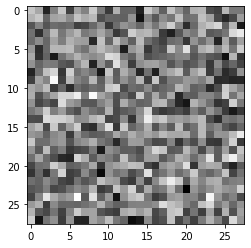

In [ ]:
input1=np.random.random(size=(1,latent_dim))
plt.imshow(input1, cmap='gray')
plt.axis('off')
plt.show()

label=MFy_train[0][None, ...]
predict_cond_gen=cond_gen.predict([input1,label])
plt.imshow(predict_cond_gen[0].reshape(img_height,img_width), cmap='gray')
plt.show()

In [ ]:
def create_cond_discriminator():
  discriminator=Sequential()
  discriminator.add(Dense(2512, input_dim= np.prod(img_shape)))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dense(2256))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dense(1, activation='sigmoid'))

  img=Input(shape=img_shape)
  label=Input(shape=(img_shape))
  flat_img = Flatten()(img)
  label_fl=Flatten()(label)
  model_input = multiply([flat_img, label_fl])
  validity=discriminator(model_input)

  discriminator = Model([img, label], validity)

  discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  discriminator.trainable=False # freeze discriminator's weights
  return discriminator

In [ ]:
cond_dis=create_cond_discriminator()
cond_dis.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_3[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
label=MFy_train[0][None, ...]
predict_cond_dis=cond_dis.predict([predict_cond_gen, label])
predict_cond_dis

array([[0.5146399]], dtype=float32)

In [ ]:
lbls_images=np.array(lbls_images)
lbls_images=lbls_images.reshape(len(lbls_images),img_height,img_width, 1)
lbls_images.shape

(10, 28, 28, 1)

In [ ]:
def sample_images_conditional(epoch, gen, lbls):  # Функция печати изображений
  r, c = 2, 5 # Параметры вывода (количество строк (r) и количество столбцов (c))
  noise = np.random.normal(0, 1, (r * c, latent_dim)) # Создаем вектор размерностью (r*c,latent_dim (10,100)) из нормально распределенных значений
  lbls=lbls[:(r * c)]
  gen_imgs = gen.predict([noise, lbls]) # Предиктим картинку с помощью входной переменной gen

  gen_imgs = 0.5 * gen_imgs + 0.5 # Трансформируем значения в диапазон от 0 до 1

  fig, axs = plt.subplots(r, c) # Создаем окно вывода r на c (2 на 5) ячеек
  cnt = 0 # Порядковый номер картинки
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray') # Записываем в axs[i,j] сгенерироввнное изображение из gen_img с индексом cnt
          axs[i,j].axis('off') # Отключаем печать названия осей
          cnt += 1 # Увеличиваем индекс изображения
  plt.show()  # Рисуем сгенерированные изображения
  #fig.savefig("images/%d.png" % epoch) # Сохраняем изображения в папке images
  plt.close()# Завершаем работу с plt 

In [ ]:
def train_conditional(generator, discriminator, epochs=30000, batch_size=128): # Функция обучения
  
  valid = np.ones((batch_size, 1)) # Создаем массив единиц длинной batch_size
  fake = np.zeros((batch_size, 1)) # Создаем массив нулей длинной batch_size
  
  noise = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
  label=Input(shape=(img_shape))
  img = generator([noise, label]) # Записываем в переменную img значение, возвращаемое generator'ом  с входными параметрами noise и label

  val = discriminator([img, label]) # Записываем в переменную val значение, возвращаемое discriminator'ом с входными параметрами img и label
  
  combined = Model([noise, label], val) # Создаем полную сеть combined (входные данные: noise и label, выходные данне: val)
  combined.compile(loss=['binary_crossentropy'], optimizer=optimizer) # Компилируем сеть combined, используя в качестве функции ошибки binary_crossentropy
  
  sample_interval = 200 # Указываем интервал, через который будем текущие сгенерированые изображения
  
  d_loss_list = [] # Массив значений ошибки дескриминатора
  g_loss_list = [] # Массив значений ошибки генератора
  d_acc_list = [] # Массив значений точности модели
  
  for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    idx = np.random.randint(0, Fx_train.shape[0], batch_size) # Создаем массив случайных значений в диапазоне от 0 до X_train.shape[0] длинной batch_size
    imgs, labels = Fx_train[idx], MFy_train[idx]  # В переменную imgs записываем значение из X_train с индексами из idx, в переменную labels записываем значения из y_train с индексами из idx

    noise = np.random.normal(0, 1, (batch_size, latent_dim)) # Создаем массив размерностью (batch_size,latent_dim) из нормально распределенных значений 

    gen_imgs = generator.predict([noise, labels]) # Предиктим картинку с помощью входной переменной generator
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], valid) # Получаем ошибку дискриминатора, обученного на реальной картинке (для этого передаем в функцию train_on_batch реальные изображения (imgs), метки (labels) и массив единици (valid)) 
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake) # Получаем ошибку дискриминатора, обученного на сгенерированной картинке (для этого передаем в функцию train_on_batch сгенерирпованные изображения (gen_imgs), метки (labels) и массив нулей (fake))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Получаем массив ошибок дискриминатора (поэлементно складываем массивы d_loss_real и d_loss_fake) и делим каждое значение пополам

    # ---------------------
    #  Train Generator
    # ---------------------

    #sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1) # Получаем массив случайных меток от 0 до 10 размерностью batch_size и решейпим его в размерность (batch_size, 1)
    
    g_loss = combined.train_on_batch([noise, labels], valid) # Получаем ошибку генератора (для этого передаем в функцию train_on_batch шум (noise), метки (sampled_labels) и массив единиц (valid))

    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)) # Печатаем номер эпохи и значения ошибок на этой эпохе

    d_loss_list.append(d_loss[0]) # Добавляем в маасив значений ошибок дискриматора первое значение в массиве d_loss
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    d_acc_list.append(100*d_loss[1]) # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100
    
    # Проверяем на условие вывода информации раз в sample_interval эпох
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)):
      clear_output()
      sample_images_conditional(epoch, generator, labels)
        
  # Выводим графики, 1 - график ошибок дискриминатора и генератора, 2 - график точности распознавания
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()

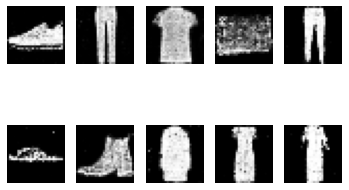

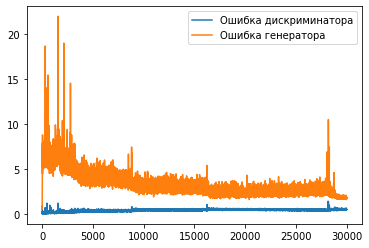

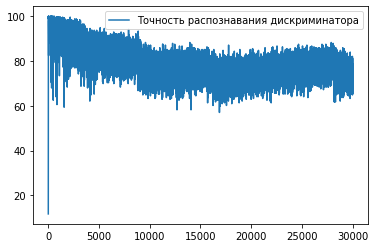

In [ ]:
optimizer=Adam(0.0001,0.5)
cond_generator = create_cond_generator() 
cond_discriminator = create_cond_discriminator()
train_conditional(cond_generator, cond_discriminator)

In [ ]:
cond_generator.save_weights('/content/drive/MyDrive/cgan_train.h5')
cond_discriminator.save_weights('/content/drive/MyDrive/cgan_disc.h5')

In [ ]:
#cond_generator.load_weights('/content/drive/MyDrive/cgan_train.h5')
#cond_discriminator.load_weights('/content/drive/MyDrive/cgan_disc.h5')

In [ ]:
#optimizer=Adam(0.00001,0.5)
#train_conditional(cond_generator, cond_discriminator)